# Model Predictive Control (7) - Linear MPC

## Table of contents <a class="anchor" id="toc"></a>


### [Linear MPC](#Notebook)
[Slides](#theory) / [Kronecker product](#kron) / [Model as an Equality Constraint](#modelconstraints) / [The Quadratic Cost](#cost) / [The Linear Constraints](#constraints) / [Example](#example)

In [1]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
from scipy.integrate import odeint
from scipy import linalg
import matplotlib.pyplot as plt
import control
import time
import cvxpy as cp
from tqdm import tqdm

files_root = "https://www.mazenalamir.fr/MPC/"

width=800

## This notebook<a class="anchor" id="Notebook"></a>

The previous notebook underlined the fact that knowing that the underlying optimal control problem is quadratic can help us accelerating the resolution of the optimization problem by a significant facor thanks to the far more efficient QP solvers. 

In this notebook, we shall through the steps that enables to put the underlying problems into QP form. This is possible under the following conditions:

1. The model of the system is affine in the state and the control

2. The cost function is exressed as a quadratic form in the state and control trajectories.

3. The constaints are expressed in affine form in the same variable. 

In this notebook, we restrict ourselves to the particular case where the constraints are **box constraints** (saturation) in the state and the control. It is left to the reader to generalize to the complete general case without difficulties. 

## MPC for Linear Time Invariant (LTI) system with quadratic cost and linear constraints<a class="anchor" id="theory"></a>

In [2]:
# Do not hesitate to change the width ad the hight in the IFrame Instruction below to fit your window. 
Introduction = files_root+"LTI_Systems_QP.pdf"
display(IFrame(Introduction, width=width, height=500))

# Python implementation 

## The kronecker product<a class="anchor" id="kron"></a>

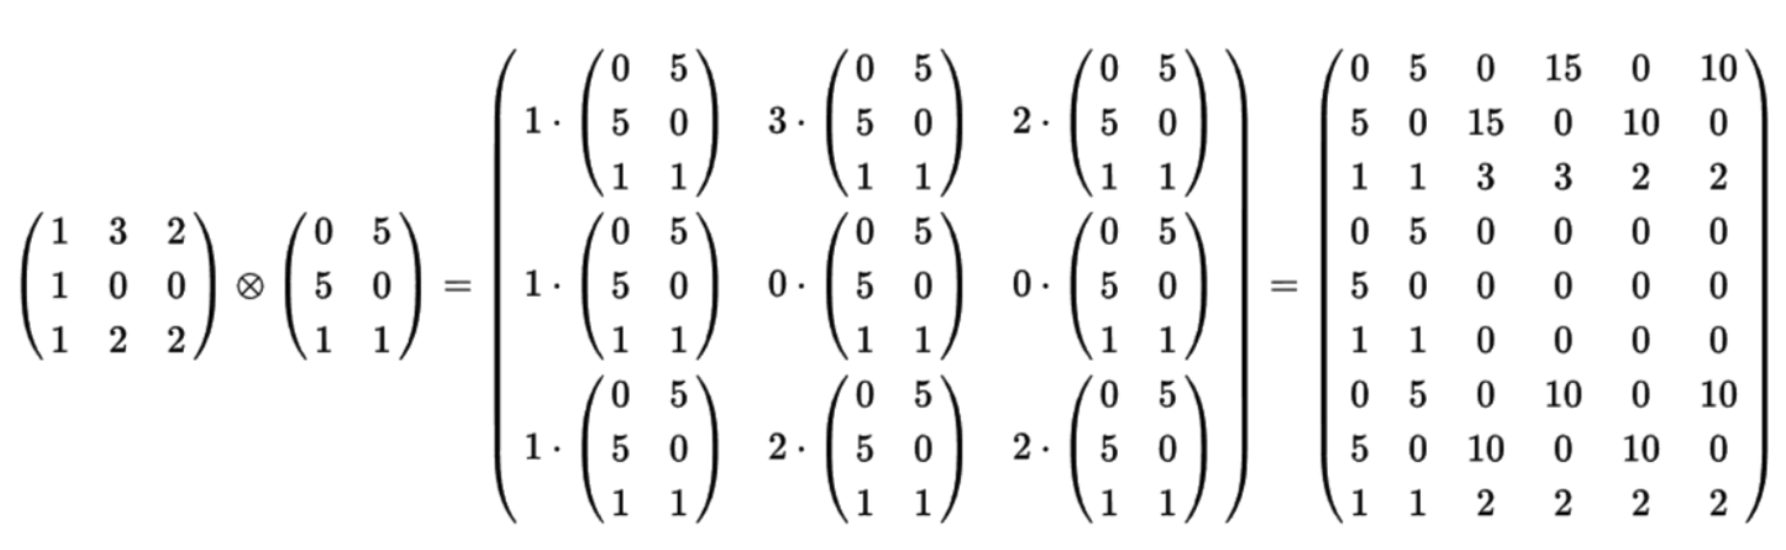

In [3]:
to_keep_in_mind = files_root+"kron.png"
display(Image(to_keep_in_mind, width=width))

In [4]:
A1 = np.array([[1,3,2], [1,0,0], [1, 2, 2]])
A2 = np.array([[0,5], [5,0], [1,1]])
np.kron(A1,A2)

array([[ 0,  5,  0, 15,  0, 10],
       [ 5,  0, 15,  0, 10,  0],
       [ 1,  1,  3,  3,  2,  2],
       [ 0,  5,  0,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0],
       [ 0,  5,  0, 10,  0, 10],
       [ 5,  0, 10,  0, 10,  0],
       [ 1,  1,  2,  2,  2,  2]])

## The dynamics of LTI systems as a linear equality constraint<a class="anchor" id="modelconstraints"></a>

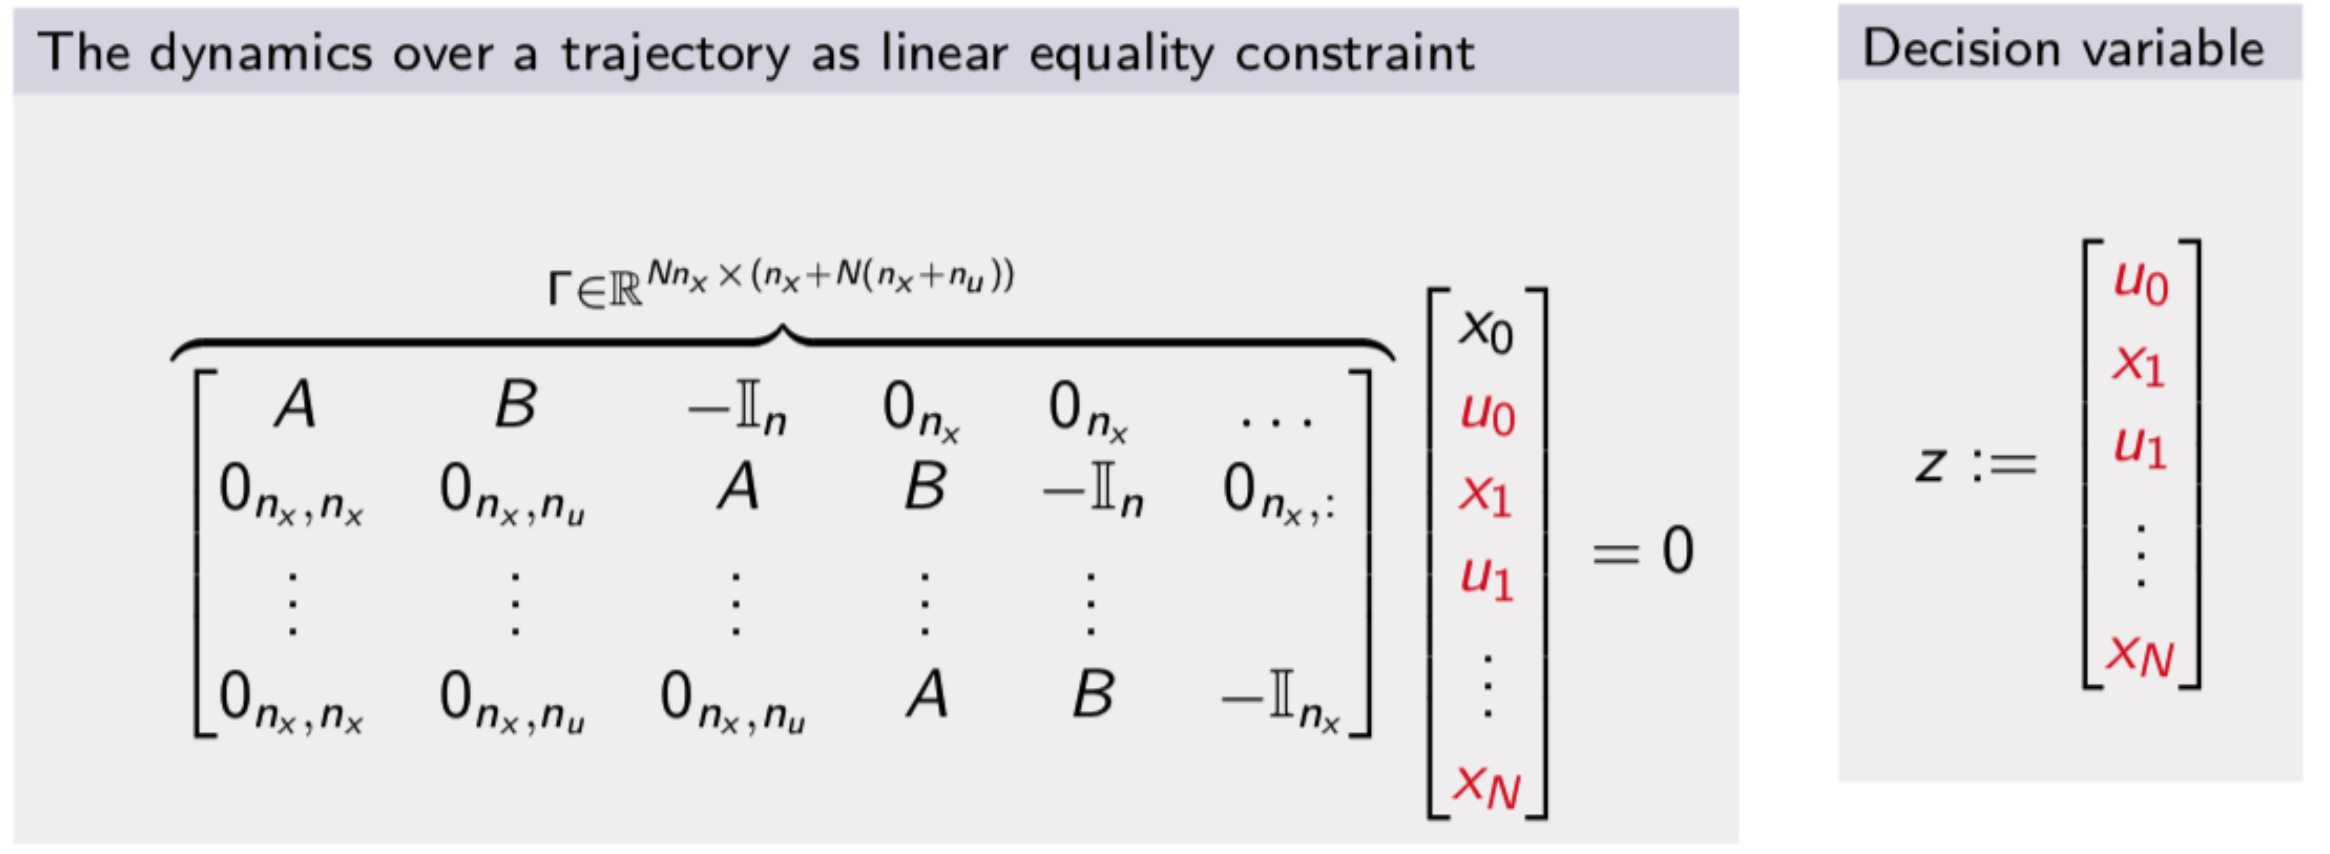

In [5]:
to_keep_in_mind = files_root+"LTI_eq_constr.png"
display(Image(to_keep_in_mind, width=width))

## NOTA

In what follows, the matrices $A$ and $B$ of the LTI system have to be expressed in **DISCRETE-TIME**

In [6]:
# Be Careful, the matrices A and B need to be in discrete-time. 

def construct_Gamma(A,B,N):
    
    nx = A.shape[0]
    nu = B.shape[1]
    I = np.eye(nx)
    Gam = np.zeros((N*nx,nx+N*(nx+nu)))
    Minter = np.hstack([A,B,-I])
    
    for i in range(N):
        Gam[i*nx:(i+1)*nx, i*(nx+nu):i*(nx+nu)+2*nx+nu] = Minter
        
    Phi = Gam[:,0:nx]
    Psi = Gam[:,nx:]
    return Phi, Psi

## Check the construction of Phi and Psi

In [38]:
# create a fictitious LTI system

nx, nu, N = 4, 2, 50
x0 = np.random.randn(nx)
A = 0.4 * np.random.randn(nx,nx)
B = np.random.randn(nx,nu)

# Compute the matrices Phi and Psi
Phi, Psi = construct_Gamma(A, B, N)

# siulate the system for a random sequence of input U

U = [np.random.randn(nu) for _ in range(N)]
Z = []
X = [x0]
for k in range(N):
    Z += [U[k]]
    X += [np.matmul(A,X[-1])+np.matmul(B, U[k])]
    Z += [X[-1]]
    
# Extract the z vector as defined above    
z = []
for item in Z:
    z += list(item)
    
# Check the equality Phi*x0+Psi*z=0    
abs(np.matmul(Phi, x0)+np.matmul(Psi,z)).max()

9.094947017729282e-13

## The quadratic cost for the regulation problem<a class="anchor" id="cost"></a>

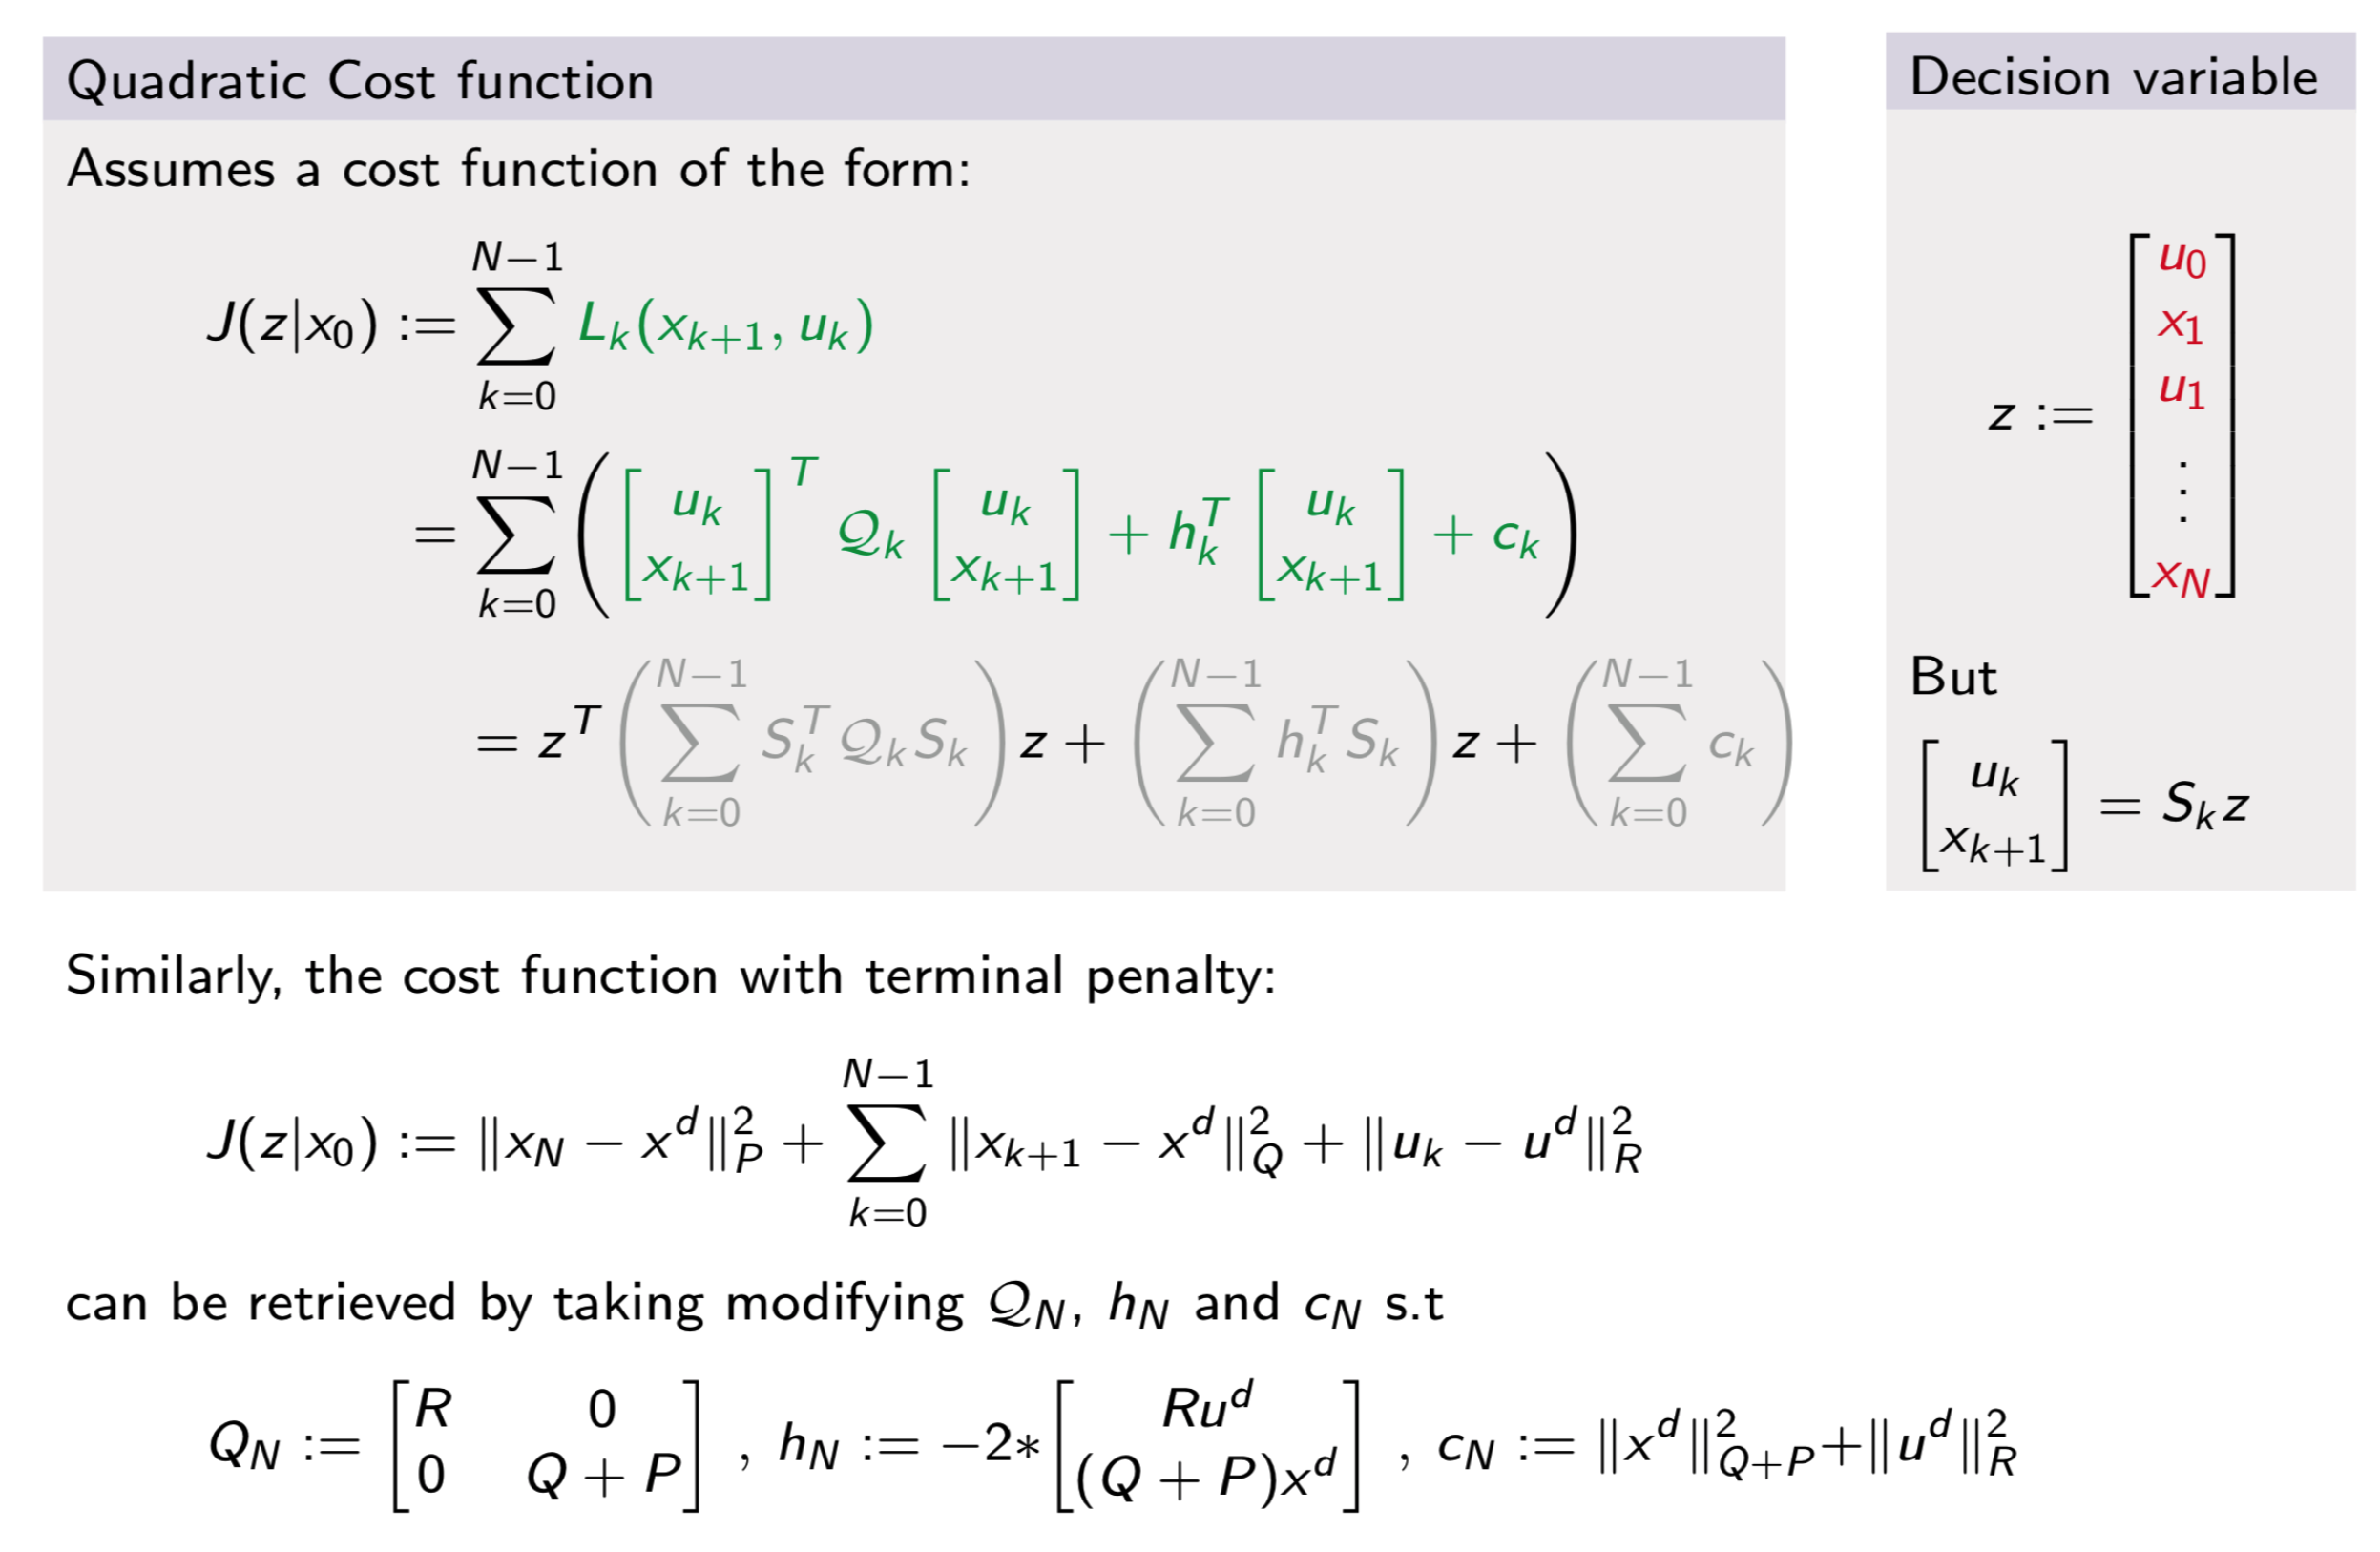

In [39]:
to_keep_in_mind = files_root+"QPLTI.png"
display(Image(to_keep_in_mind, width=width))

In [40]:
def compute_cost_matrices(Q, R, P, N, xd, ud):
    
    xd = xd.reshape(-1,1)
    ud = ud.reshape(-1,1)
    nx, nu = Q.shape[0], R.shape[0]
    nz = N * (nx+nu)
    H, h = np.zeros((nz, nz)), np.zeros((nz,1))
    
    Qk = linalg.block_diag(R, Q)
    QN = linalg.block_diag(R, Q+P)
    hk = -2*np.vstack([np.matmul(R, ud), np.matmul(Q, xd)])
    hN = -2*np.vstack([np.matmul(R, ud), np.matmul(Q+P, xd)])    
    I = np.eye(N)
    for k in range(N):
        Sk = np.kron(I[k,:], np.eye(nx+nu))
        if k<N-1:
            H += np.matmul(Sk.T, np.matmul(Qk, Sk))
            h += np.matmul(Sk.T, hk)
        else:
            H += np.matmul(Sk.T, np.matmul(QN, Sk))
            h += np.matmul(Sk.T, hN)
            
    return H, h

In the previous function, one would have to repeat the whole computation at each instant since (xd,ud) might change at any instant during the system lifetime. 

This would be a lost of time since:

- $H$ is a constant matrix (for a given system, given $N$ and given penalty matrices $Q$, $R$ and $P$)
- $h$ is known to be an affine function of (xd,ud), namely:

$$h = M_1 x^d + M_2 u^d\qquad M_1\in \mathbb R^{n_z\times n_x}\quad   M_2\in \mathbb R^{n_z\times n_u}$$

This can be done by rewriting the function *compute_cost_matrices* so that it delivers as outputs $H$, $M_1$ and $M_2$. 

This is skipped here and left to the reader. 

## Construct the saturation constraints on state and control as a linear constraint<a class="anchor" id="constraints"></a>

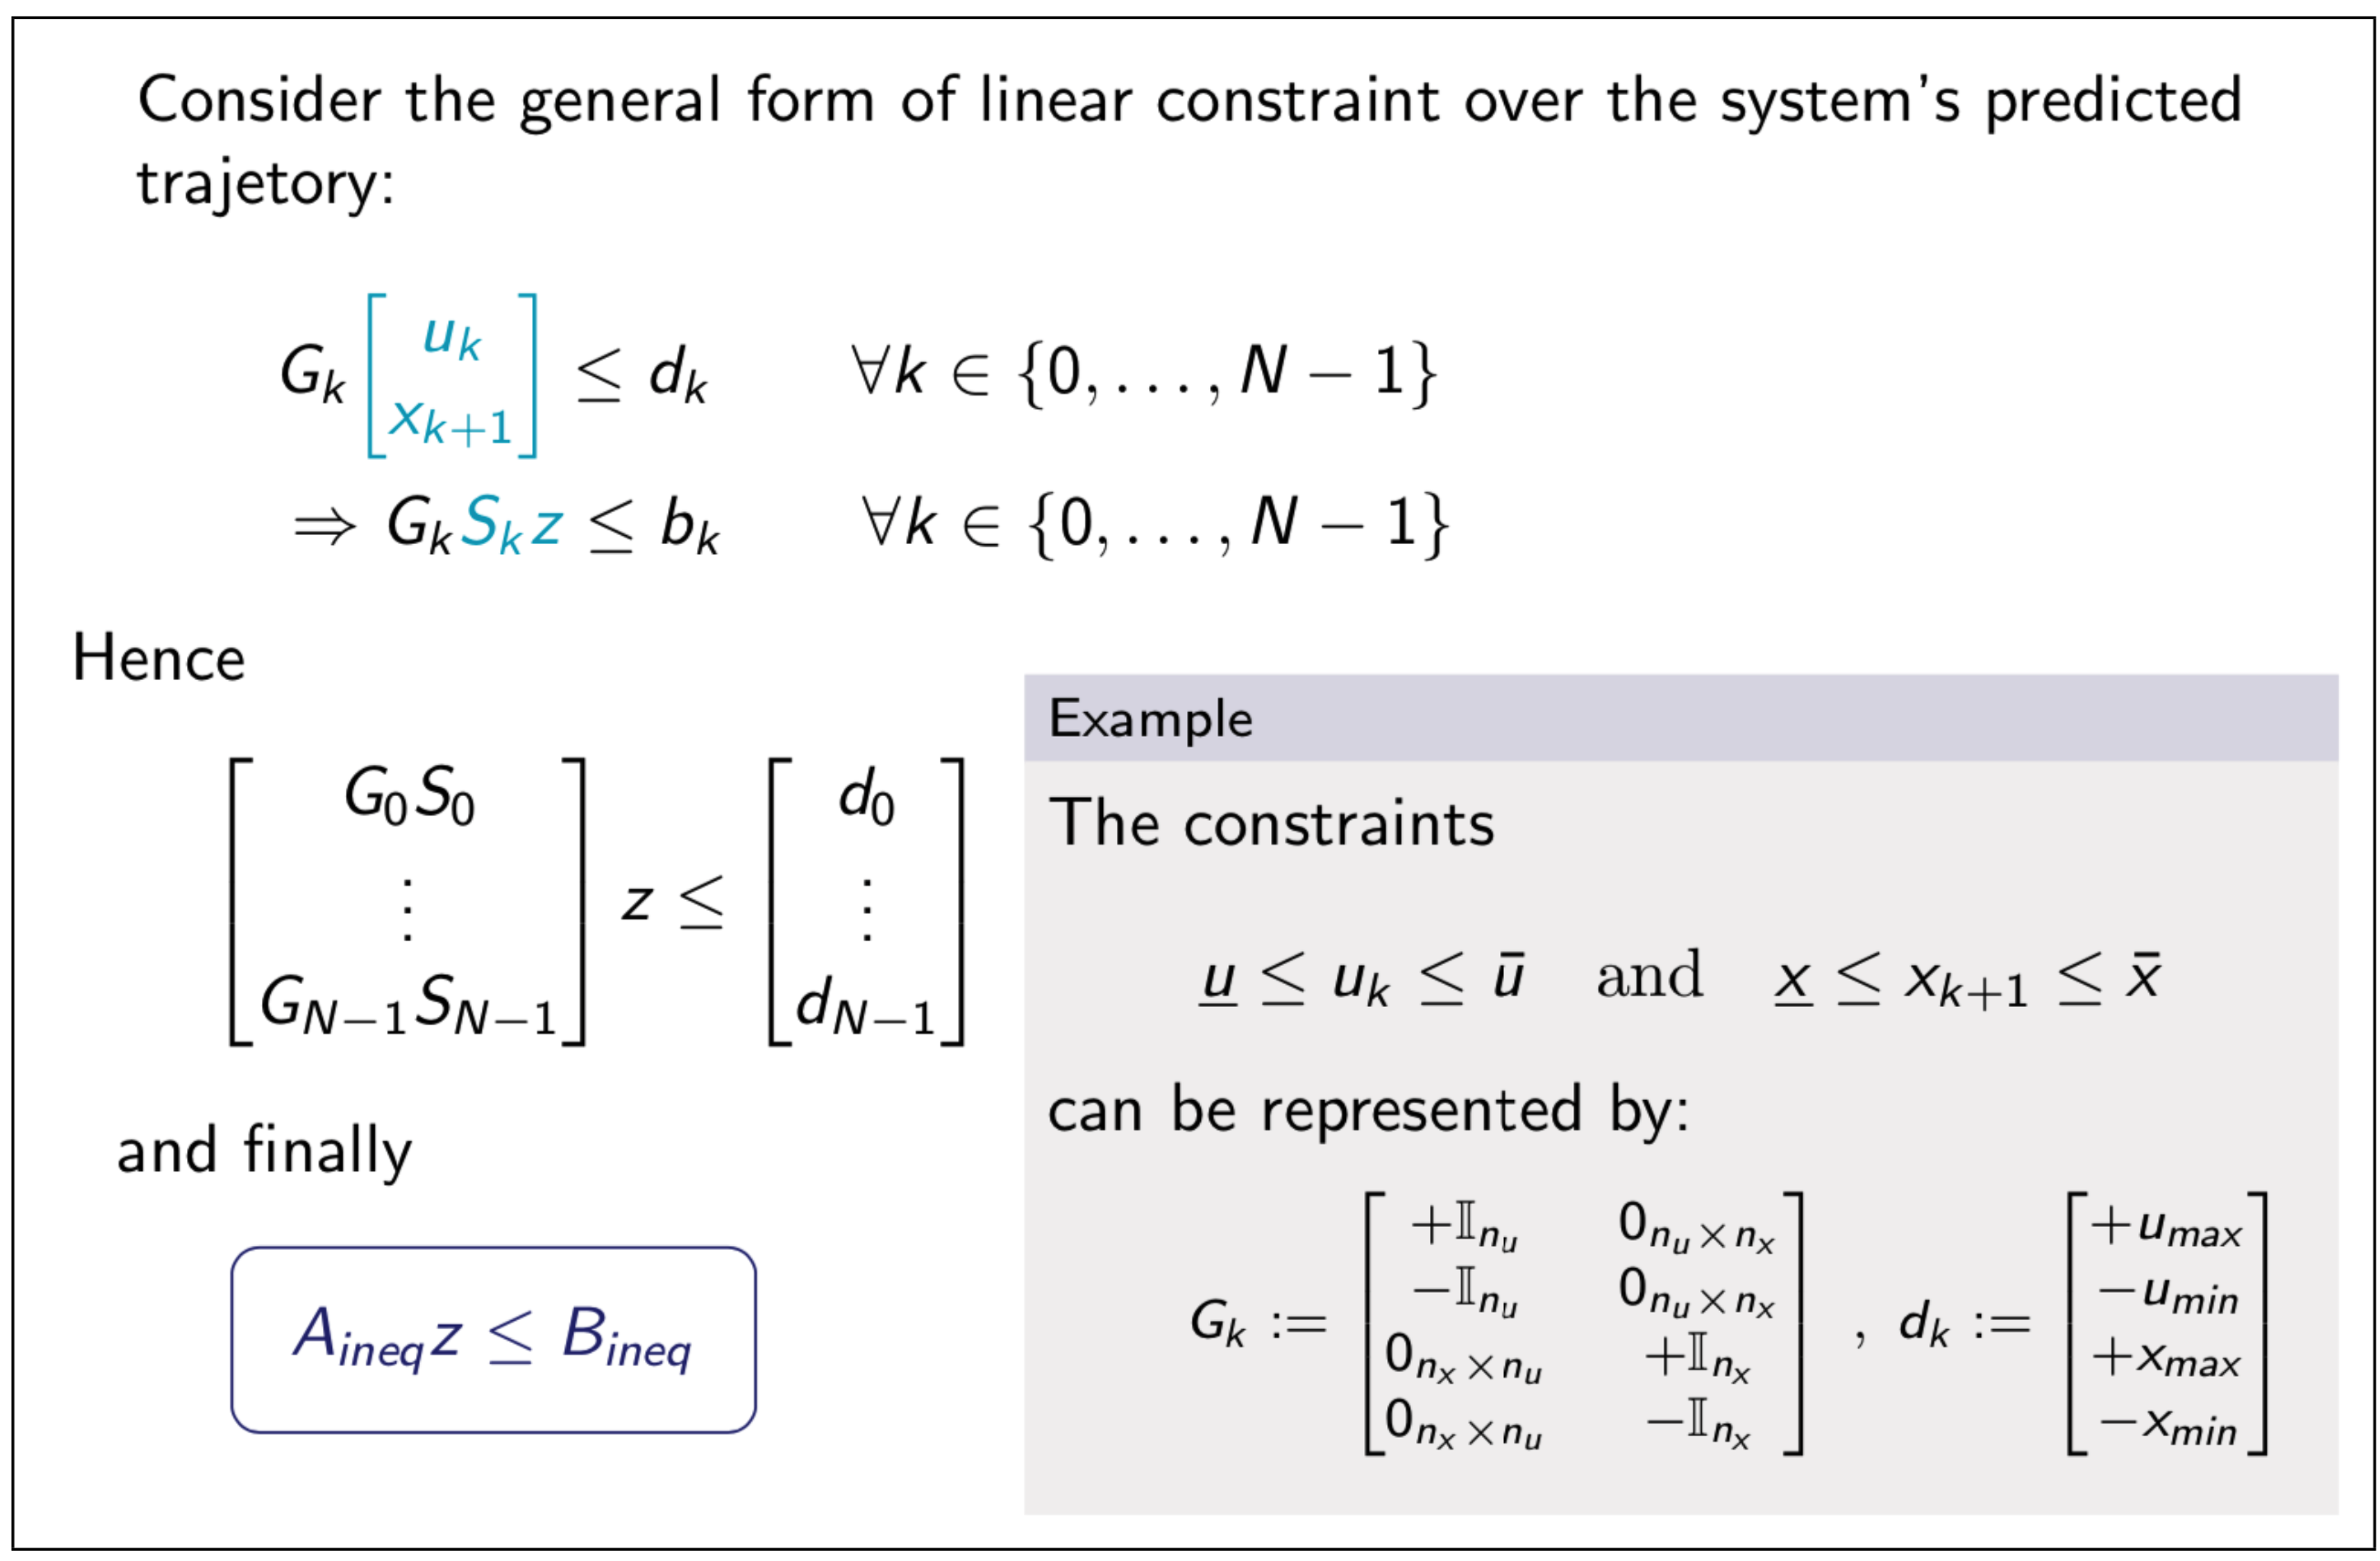

In [41]:
to_keep_in_mind = files_root+"linearconstraints.png"
display(Image(to_keep_in_mind, width=width))

## Implementation of the constraints matrices computation

In [42]:
def construct_constraints_matrices(umin, umax, xmin, xmax,N):
    
    nx, nu = len(xmin), len(umin)
    I = np.eye(N)
    
    Gk_1 = np.hstack([np.eye(nu), np.zeros((nu, nx))])
    Gk_2 = np.hstack([-np.eye(nu), np.zeros((nu, nx))])
    Gk_3 = np.hstack([np.zeros((nx, nu)), np.eye(nx)])
    Gk_4 = np.hstack([np.zeros((nx, nu)), -np.eye(nx)])
    Gk = np.vstack([Gk_1, Gk_2, Gk_3, Gk_4])
    
    dk = np.vstack([umax.reshape(-1,1), 
                    -umin.reshape(-1,1), 
                    xmax.reshape(-1,1), 
                    -xmin.reshape(-1,1)])
    
    Bineq = np.kron(np.ones((N,1)), dk)
    Aineq = np.zeros((2*N*(nx+nu), N*(nx+nu)))
    for k in range(N):
        Sk = np.kron(I[k,:], np.eye(nx+nu))
        Aineq[k*2*(nx+nu):(k+1)*2*(nx+nu), :] = np.matmul(Gk, Sk)
        
    return Aineq, Bineq

## Example: The constrained triple intergrator<a class="anchor" id="example"></a>

Consider the triple integrator system given by

\begin{align}
\dot x_1 &= x_2\\
\dot x_2 &= x_3\\
\dot x_3 &= u
\end{align}

with the saturation constraints on the inputs $u$

$$\vert u\vert < 0.5$$

and the saturation constraints on the state given by:

$$x_{min} = \begin{bmatrix}
-2\cr -0.2\cr -20
\end{bmatrix}\quad ;\quad x_{min} = \begin{bmatrix}
2\cr 0.2\cr 20
\end{bmatrix}
$$

The control objective is to regulate the state around the reference value given by:

$$
x^d = \begin{bmatrix}
y^d\cr 0\cr 0
\end{bmatrix}\qquad;\qquad u^d=0
$$

while satisfying the above mentioned set of constraints. 

**We shall use a sampling period of 0.2 sec** and a prediction horizon of $N=20$

## Continuous time matrices 

In [43]:
Ac = np.array([[0, 1, 0], [0, 0, 1], [0,0,0]])
Bc = np.array([[0,0,1]]).T
Cc = np.array([1,0,0])
Dc = [0]

## Discrete-time matrices 

As mentioned above, we need the discrete-time State-space representation of the system. 

**Fortunately, the python control** module helps us to get this representation (Hint: in the search field, look for "ss" and "c2d" function)

In [44]:
display(IFrame("https://python-control.readthedocs.io/en/0.8.4/intro.html", width=width, height=600))

In [45]:
# declare the contrinuous-time dynamics

systc = control.ss(Ac, Bc, Cc, Dc)

# compute the exact discretization of the system 

dt = 0.2
systd = control.c2d(systc, dt)

systd

StateSpace(array([[1.  , 0.2 , 0.02],
       [0.  , 1.  , 0.2 ],
       [0.  , 0.  , 1.  ]]), array([[0.00133333],
       [0.02      ],
       [0.2       ]]), array([[1., 0., 0.]]), array([[0.]]), 0.2)

## Computation of the dynamics matrices $\Psi$ and $\Phi$

In [46]:
# Extract the discrete matrices A and B

A = systd.A
B = systd.B

# compute the matrices Psi and Phi involved in the equality constraints
# Phi*x0+Psi*z=0

Phi, Psi = construct_Gamma(A, B, N)

# check the dimensions 

print(f'Dimension of Phi = {Phi.shape}')
print(f'Dimension of Psi = {Psi.shape}')

Dimension of Phi = (150, 3)
Dimension of Psi = (150, 200)


## Computation of the cost matrices $H$ and $h$

In [47]:
n = A.shape[0]
nu = 1
Q = np.eye(n)
R = 0.1*np.eye(1)
P = 100 * np.eye(n)
xd, ud = np.array([1,0,0]), np.array([0])

H, h = compute_cost_matrices(Q, R, P, N, xd, ud)

print(f'size of H = {H.shape}')
print(f'size of h = {h.shape}')

size of H = (200, 200)
size of h = (200, 1)


## Computation of the constraints matrices Aineq and Bineq

In [48]:
umin = np.array([-0.5])
umax = np.array([+0.5])
xmin = np.array([-2, -0.2, -20])
xmax = np.array([+2, +0.2, +20])
Aineq, Bineq = construct_constraints_matrices(umin, umax, xmin, xmax,N)


print(f'shape of Aineq = {Aineq.shape}')
print(f'shape of Bineq = {Bineq.shape}')
print(f'number of constraints = {(len(xmin)*2+len(umin)*2)*N}')
print(f'number of decision variables = {(len(xmin)+len(umin))*N}')

shape of Aineq = (400, 200)
shape of Bineq = (400, 1)
number of constraints = 400
number of decision variables = 200


## Check the open-loop problem solution using CVXPY

Now we have all we need to call a QP solver such as CVXPY (seen in a previous notebook) in order to solve a single instance of the optimal control problem. Recall the repetitive solution of such problem leads to the MPC feedback. For the time being let us first check a single instance (for a given state and a given set point pair (xd, ud).

In [49]:
display(IFrame("https://www.cvxpy.org/examples/basic/quadratic_program.html", width=width, height=600))

In [50]:
# initial state
x0 = np.array([0,0,0]).T

# the QP problem to be solved

z = cp.Variable(Psi.shape[1])
problem = cp.Problem(
    
    cp.Minimize(cp.quad_form(z,H)+h.T@z), 
    [Aineq@z <= Bineq[:,0], 
     Psi@z == -Phi @ x0]
)
t1 = time.time()
problem.solve();
print(f'cpu time = {time.time()-t1}')
z = z.value.reshape(-1,4)

cpu time = 0.0398249626159668


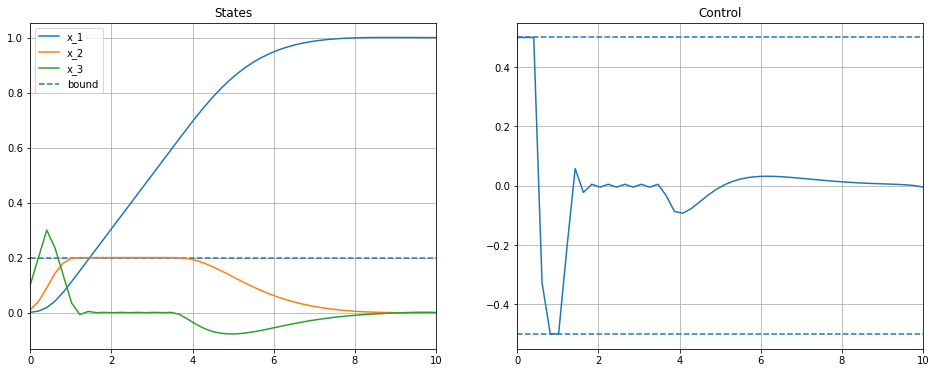

In [51]:
u_profile = z[:,0]
x_profile = z[:,1:]
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
t = np.linspace(0,N*dt,N)
#---
ax[0].plot(t,x_profile)
ax[0].hlines(xmax[1], 0, N, linestyles='--')
ax[0].legend(['x_1', 'x_2', 'x_3', 'bound'])
ax[0].set_xlim([0,N*dt])
ax[0].grid(True)
ax[0].set_title('States')
#---
ax[1].plot(t,u_profile)
ax[1].set_xlim([0,N*dt])
ax[1].hlines([umin[0], umax[0]], 0, N, linestyles='--')
ax[1].set_title('Control')
ax[1].grid(True)

The use of this open-loop solution repeatedly in order to obtain an MPC feedback can be done in the same way as in the nonlinear case studied earlier in a previous notebook. 

More precisely, the current state shouled replace x0 in the definition of the right hand side of the equality constraint in the call: 


problem = cp.Problem(
    cp.Minimize(cp.quad_form(z,H)+h.T@z), 
    [Aineq@z <= Bineq[:,0], 
     Psi@z == -Phi @ x0]
)

## Checkpoint 6: Close the loop by MPC controller

In this checkpoint we want to close the loop using MPC principle.

1. Code the closed-loop simulation loop (simulate for $N_{sim}=100$ sampling periods)
2. Produce the closed-loop results for the following values of the prediction horizon:

$$N \in \{2, 5, 10, 50\}$$

For each value, change the value of $N$ in the cell where $N$ is defined and re-execute the whole notebook to get the results.

3. Report the results and comment in particular the differences between the initial open-loop solution and the closed loop one. 

4. give also the histograms of computation times during the closed-loop simulations for each value of $N$.  

In [52]:
x0 = np.array([0,0,0])
Xcl = [x0]
Ucl = []
cpu_cl = []
Nsim = 100
z = cp.Variable(Psi.shape[1])

for k in tqdm(range(Nsim)):

    problem = cp.Problem(
            cp.Minimize(cp.quad_form(z,H)+h.T@z), 
            [Aineq@z <=  Bineq[:,0], 
            Psi@z == -Phi @ Xcl[-1]])
    t1 = time.time()
    problem.solve()
    cpu_cl.append([time.time()-t1])
    Ucl.append([z.value[0]])
    Xcl.append(np.matmul(A,Xcl[-1])+np.matmul(B, Ucl[-1]))
    
Xcl = np.array(Xcl)
Ucl = np.array(Ucl)
tcl = np.linspace(0, Nsim * dt, len(Xcl))
cpu_cl = np.array(cpu_cl)

100%|██████████| 100/100 [00:01<00:00, 73.72it/s]


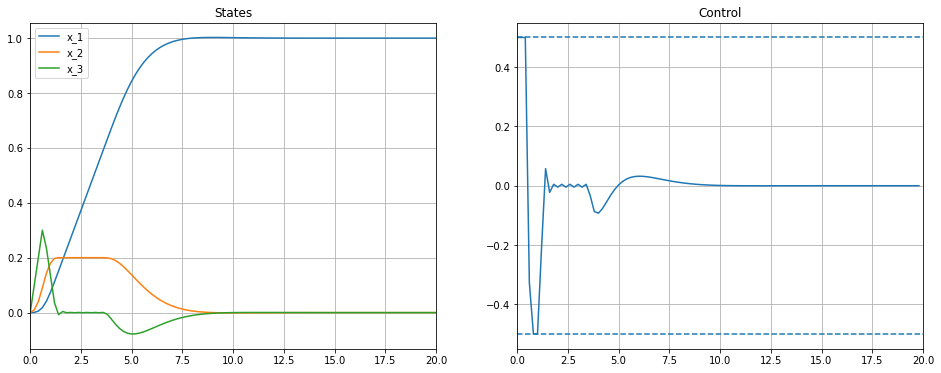

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
#---
ax[0].plot(tcl,Xcl)
#ax[0].hlines(xmax[1], 0, N, linestyles='--')
ax[0].legend(['x_1', 'x_2', 'x_3', 'bound'])
ax[0].set_xlim([0,tcl.max()])
ax[0].grid(True)
ax[0].set_title('States')
#---
ax[1].plot(tcl[0:-1],Ucl)
ax[1].set_xlim([0,tcl.max()])
ax[1].hlines([umin[0], umax[0]], 0, Nsim, linestyles='--')
ax[1].set_title('Control')
ax[1].grid(True)

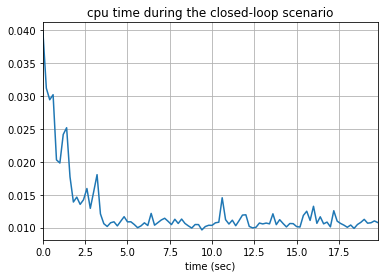

In [54]:
plt.plot(tcl[0:-1], cpu_cl)
plt.xlim([0, tcl[0:-1].max()])
plt.title('cpu time during the closed-loop scenario')
plt.xlabel('time (sec)')
plt.grid(True)

In [56]:
#%load_ext watermark
#print("----")
#%watermark -v -m -p IPython,ipywidgets,casadi,scipy,matplotlib,control,tqdm
#print("----")
#%watermark -u -n -t -z